# Home 4: Build a CNN for image recognition.

### Name: Ayman Elkfrawy


## 0. You will do the following:

1. Read, complete, and run the code.

2. **Make substantial improvements** to maximize the accurcy.
    
3. Convert the .IPYNB file to .HTML file.

    * The HTML file must contain the code and the output after execution.
    
    * Missing **the output after execution** will not be graded.
    
4. Upload this .HTML file to your Google Drive, Dropbox, or Github repo. (If you submit the file to Google Drive or Dropbox, you must make the file "open-access". The delay caused by "deny of access" may result in late penalty.)

4. Submit the link to this .HTML file to Canvas.

    * Example: https://github.com/wangshusen/CS583-2020S/blob/master/homework/HM4/HM4.html


## Requirements:

1. You can use whatever CNN architecture, including VGG, Inception, and ResNet. However, you must build the networks layer by layer. You must NOT import the archetectures from ```keras.applications```.

2. Make sure ```BatchNormalization``` is between a ```Conv```/```Dense``` layer and an ```activation``` layer.

3. If you want to regularize a ```Conv```/```Dense``` layer, you should place a ```Dropout``` layer **before** the ```Conv```/```Dense``` layer.

4. An accuracy above 70% is considered reasonable. An accuracy above 80% is considered good. Without data augmentation, achieving 80% accuracy is difficult.


## Google Colab

- If you do not have GPU, the training of a CNN can be slow. Google Colab is a good option.

- Keep in mind that you must download it as an IPYNB file and then use IPython Notebook to convert it to HTML.

- Also keep in mind that the IPYNB and HTML files must contain the outputs. (Otherwise, the instructor will not be able to know the correctness and performance.) Do the followings to keep the outputs.

- In Colab, go to ```Runtime``` --> ```Change runtime type``` --> Do NOT check ```Omit code cell output when saving this notebook```. In this way, the downloaded IPYNB file contains the outputs.

## 1. Data preparation

### 1.1. Load data


In [24]:
from keras.datasets import cifar10
import numpy

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train = x_train / 255.0
x_test = x_test / 255.0

print('shape of x_train: ' + str(x_train.shape))
print('shape of y_train: ' + str(y_train.shape))
print('shape of x_test: ' + str(x_test.shape))
print('shape of y_test: ' + str(y_test.shape))
print('number of classes: ' + str(numpy.max(y_train) - numpy.min(y_train) + 1))

shape of x_train: (50000, 32, 32, 3)
shape of y_train: (50000, 1)
shape of x_test: (10000, 32, 32, 3)
shape of y_test: (10000, 1)
number of classes: 10


### 1.2. One-hot encode the labels

In the input, a label is a scalar in $\{0, 1, \cdots , 9\}$. One-hot encode transform such a scalar to a $10$-dim vector. E.g., a scalar ```y_train[j]=3``` is transformed to the vector ```y_train_vec[j]=[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]```.

1. Define a function ```to_one_hot``` that transforms an $n\times 1$ array to a $n\times 10$ matrix.

2. Apply the function to ```y_train``` and ```y_test```.

In [25]:
def to_one_hot(y, num_class=10):
    result = numpy.zeros((len(y), num_class))
    for i, y_value in enumerate(y):
      result[i, y_value] = 1.0
    return result

y_train_vec = to_one_hot(y_train)
y_test_vec = to_one_hot(y_test)

print('Shape of y_train_vec: ' + str(y_train_vec.shape))
print('Shape of y_test_vec: ' + str(y_test_vec.shape))

print(y_train[0])
print(y_train_vec[0])

Shape of y_train_vec: (50000, 10)
Shape of y_test_vec: (10000, 10)
[6]
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


#### Remark: the outputs should be
* Shape of y_train_vec: (50000, 10)
* Shape of y_test_vec: (10000, 10)
* [6]
* [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]

### 1.3. Randomly partition the training set to training and validation sets

Randomly partition the 50K training samples to 2 sets:
* a training set containing 40K samples
* a validation set containing 10K samples


In [26]:
rand_indices = numpy.random.permutation(50000)
train_indices = rand_indices[0:40000]
valid_indices = rand_indices[40000:50000]

x_val = x_train[valid_indices, :]
y_val = y_train_vec[valid_indices, :]

x_tr = x_train[train_indices, :]
y_tr = y_train_vec[train_indices, :]

print('Shape of x_tr: ' + str(x_tr.shape))
print('Shape of y_tr: ' + str(y_tr.shape))
print('Shape of x_val: ' + str(x_val.shape))
print('Shape of y_val: ' + str(y_val.shape))

Shape of x_tr: (40000, 32, 32, 3)
Shape of y_tr: (40000, 10)
Shape of x_val: (10000, 32, 32, 3)
Shape of y_val: (10000, 10)


## 2. Build a CNN and tune its hyper-parameters

1. Build a convolutional neural network model
2. Use the validation data to tune the hyper-parameters (e.g., network structure, and optimization algorithm)
    * Do NOT use test data for hyper-parameter tuning!!!
3. Try to achieve a validation accuracy as high as possible.

### Remark: 

The following CNN is just an example. You are supposed to make **substantial improvements** such as:
* Add more layers.
* Use regularizations, e.g., dropout.
* Use batch normalization.

In [6]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


In [27]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation, BatchNormalization
from keras.models import Sequential
from keras import optimizers

def get_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same', input_shape=(32, 32, 3)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    # model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(32, (3, 3), padding='same', input_shape=(32, 32, 3)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    # model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    # model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Flatten())

    model.add(Dropout(0.4))
    model.add(Dense(128))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(Dense(10))
    model.add(Activation('softmax'))

    model.summary()

    learning_rate = 1E-3 # to be tuned!

    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizers.RMSprop(lr=learning_rate),
                  metrics=['acc'])

    return model

model = get_model()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_31 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_36 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
activation_41 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_37 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
activation_42 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 16, 16, 32)       

In [28]:
from keras_preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    # shear_range=0.2,
    # zoom_range=0.5,
    horizontal_flip=True,
)
train_datagen.fit(x_tr)

batch_size = 64
train_gen = train_datagen.flow(x_tr, y_tr, batch_size=batch_size)

# for sample in train_gen:
#     print(sample.shape)

# validation_dataget = ImageDataGenerator()
# validation_gen = validation_dataget.flow(x_val, y_val)

history = model.fit_generator(train_gen, steps_per_epoch=int(x_tr.shape[0]/batch_size), epochs=50,
                              validation_data=(x_val, y_val), verbose=2)



Epoch 1/50
 - 211s - loss: 1.4019 - acc: 0.4938 - val_loss: 1.3377 - val_acc: 0.5444
Epoch 2/50
 - 66s - loss: 1.0131 - acc: 0.6398 - val_loss: 1.0755 - val_acc: 0.6442
Epoch 3/50
 - 65s - loss: 0.8788 - acc: 0.6890 - val_loss: 1.0191 - val_acc: 0.6561
Epoch 4/50
 - 54s - loss: 0.7995 - acc: 0.7210 - val_loss: 0.8971 - val_acc: 0.6965
Epoch 5/50
 - 53s - loss: 0.7402 - acc: 0.7406 - val_loss: 0.9292 - val_acc: 0.7095
Epoch 6/50
 - 52s - loss: 0.6927 - acc: 0.7582 - val_loss: 0.8710 - val_acc: 0.7223
Epoch 7/50
 - 51s - loss: 0.6566 - acc: 0.7708 - val_loss: 0.6745 - val_acc: 0.7630
Epoch 8/50
 - 53s - loss: 0.6254 - acc: 0.7836 - val_loss: 0.7168 - val_acc: 0.7562
Epoch 9/50
 - 52s - loss: 0.6059 - acc: 0.7890 - val_loss: 0.8186 - val_acc: 0.7428
Epoch 10/50
 - 52s - loss: 0.5816 - acc: 0.7995 - val_loss: 0.5779 - val_acc: 0.8013
Epoch 11/50
 - 51s - loss: 0.5624 - acc: 0.8045 - val_loss: 0.6352 - val_acc: 0.7942
Epoch 12/50
 - 101s - loss: 0.5435 - acc: 0.8114 - val_loss: 0.8079 - val

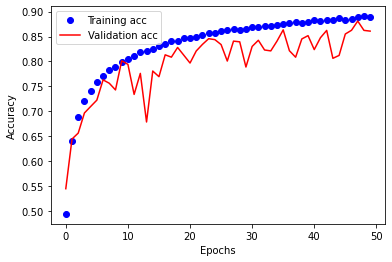

In [29]:
import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## 3. Train (again) and evaluate the model

- To this end, you have found the "best" hyper-parameters. 
- Now, fix the hyper-parameters and train the network on the entire training set (all the 50K training samples)
- Evaluate your model on the test set.

### 3.1. Train the model on the entire training set

Why? Previously, you used 40K samples for training; you wasted 10K samples for the sake of hyper-parameter tuning. Now you already know the hyper-parameters, so why not using all the 50K samples for training?

In [30]:
model = get_model()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_37 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_43 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
activation_49 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_44 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
activation_50 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 16, 16, 32)       

In [31]:
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    # shear_range=0.2,
    # zoom_range=0.5,
    horizontal_flip=True,
)
train_datagen.fit(x_train)

batch_size = 64
train_gen = train_datagen.flow(x_train, y_train_vec, batch_size=batch_size)

history = model.fit_generator(train_gen, steps_per_epoch=int(x_train.shape[0]/batch_size), epochs=50, verbose=2)

Epoch 1/50
 - 57s - loss: 1.3433 - acc: 0.5154
Epoch 2/50
 - 55s - loss: 0.9598 - acc: 0.6602
Epoch 3/50
 - 55s - loss: 0.8414 - acc: 0.7067
Epoch 4/50
 - 55s - loss: 0.7605 - acc: 0.7317
Epoch 5/50
 - 55s - loss: 0.7120 - acc: 0.7527
Epoch 6/50
 - 55s - loss: 0.6625 - acc: 0.7683
Epoch 7/50
 - 55s - loss: 0.6336 - acc: 0.7803
Epoch 8/50
 - 55s - loss: 0.6077 - acc: 0.7908
Epoch 9/50
 - 52s - loss: 0.5826 - acc: 0.7995
Epoch 10/50
 - 50s - loss: 0.5613 - acc: 0.8066
Epoch 11/50
 - 51s - loss: 0.5470 - acc: 0.8105
Epoch 12/50
 - 51s - loss: 0.5279 - acc: 0.8204
Epoch 13/50
 - 51s - loss: 0.5161 - acc: 0.8238
Epoch 14/50
 - 51s - loss: 0.5021 - acc: 0.8291
Epoch 15/50
 - 51s - loss: 0.4875 - acc: 0.8319
Epoch 16/50
 - 51s - loss: 0.4771 - acc: 0.8362
Epoch 17/50
 - 51s - loss: 0.4686 - acc: 0.8401
Epoch 18/50
 - 51s - loss: 0.4576 - acc: 0.8426
Epoch 19/50
 - 51s - loss: 0.4490 - acc: 0.8484
Epoch 20/50
 - 51s - loss: 0.4443 - acc: 0.8477
Epoch 21/50
 - 51s - loss: 0.4371 - acc: 0.8512
E

### 3.2. Evaluate the model on the test set

Do NOT used the test set until now. Make sure that your model parameters and hyper-parameters are independent of the test set.

In [33]:
loss_and_acc = model.evaluate(x_test, y_test_vec, verbose=0)
print('loss = ' + str(loss_and_acc[0]))
print('accuracy = ' + str(loss_and_acc[1]))



loss = 0.5388658176898956
accuracy = 0.8544999957084656
